<a href="https://colab.research.google.com/github/Hari-haranK/Morse-Code---Decoder/blob/main/morse_detectipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


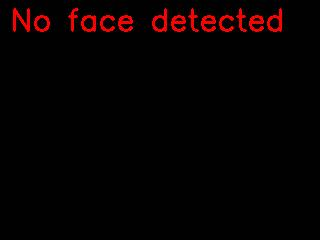

🛑 Stopping...

🏁 Final message: ''
✅ Camera cleaned up!


In [ ]:
import cv2
import time
import numpy as np
import dlib
from IPython.display import display, HTML, clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
import bz2
import requests
from tqdm import tqdm

# Make sure to use CPU only
os.environ["DLIB_USE_CUDA"] = "0"

# Simplified Morse code dictionary (most common letters)
MORSE_CODE_DICT = {
    '.-': 'A', '-...': 'B', '-.-.': 'C', '-..': 'D', '.': 'E',
    '..-.': 'F', '--.': 'G', '....': 'H', '..': 'I', '.---': 'J',
    '-.-': 'K', '.-..': 'L', '--': 'M', '-.': 'N', '---': 'O',
    '.--.': 'P', '--.-': 'Q', '.-.': 'R', '...': 'S', '-': 'T',
    '..-': 'U', '...-': 'V', '.--': 'W', '-..-': 'X', '-.--': 'Y',
    '--..': 'Z', '-----': '0', '.----': '1', '..---': '2', '...--': '3',
    '....-': '4', '.....': '5', '-....': '6', '--...': '7', '---..': '8',
    '----.': '9'
}

def download_shape_predictor():
    """Lightweight shape predictor download"""
    predictor_path = "shape_predictor_68_face_landmarks.dat"

    if os.path.isfile(predictor_path):
        try:
            # Quick validation
            test_predictor = dlib.shape_predictor(predictor_path)
            print("✅ Shape predictor ready!")
            return predictor_path
        except:
            print("⚠️ Existing file corrupted, re-downloading...")
            os.remove(predictor_path)

    print("📥 Downloading shape predictor...")
    compressed_file = predictor_path + ".bz2"

    try:
        url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(compressed_file, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True) as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))

        print("📦 Extracting...")
        with bz2.BZ2File(compressed_file, 'rb') as compressed:
            with open(predictor_path, 'wb') as output:
                output.write(compressed.read())

        os.remove(compressed_file)
        print("✅ Shape predictor ready!")
        return predictor_path

    except Exception as e:
        print(f"❌ Download failed: {e}")
        return None

class CameraManager:
    """Lightweight camera manager with proper cleanup"""
    def __init__(self):
        self.stream = None
        self.video_id = 'webcamVideo'

    def initialize(self):
        """Initialize camera stream"""
        cleanup_js = f'''
        // Clean up any existing streams
        const existingVideo = document.getElementById('{self.video_id}');
        if (existingVideo && existingVideo.srcObject) {{
            const tracks = existingVideo.srcObject.getTracks();
            tracks.forEach(track => track.stop());
            existingVideo.srcObject = null;
            existingVideo.remove();
        }}
        '''
        eval_js(cleanup_js)

        init_js = f'''
        (function() {{
            return new Promise((resolve) => {{
                const video = document.createElement('video');
                video.id = '{self.video_id}';
                video.style.display = 'none';
                video.autoplay = true;
                video.muted = true;
                document.body.appendChild(video);

                navigator.mediaDevices.getUserMedia({{
                    video: {{ width: 320, height: 240, frameRate: 10 }}
                }}).then(stream => {{
                    video.srcObject = stream;
                    video.onloadedmetadata = () => {{
                        resolve({{ success: true, width: video.videoWidth, height: video.videoHeight }});
                    }};
                    setTimeout(() => resolve({{ success: true, width: 320, height: 240 }}), 2000);
                }}).catch(error => {{
                    resolve({{ success: false, error: error.message }});
                }});
            }});
        }})()
        '''

        try:
            result = eval_js(init_js)
            if result and result.get('success'):
                print("✅ Camera initialized!")
                return True
            else:
                print(f"❌ Camera failed: {result.get('error', 'Unknown error')}")
                return False
        except Exception as e:
            print(f"❌ Camera error: {e}")
            return False

    def get_frame(self):
        """Capture single frame"""
        js_code = f'''
        (function() {{
            const video = document.getElementById('{self.video_id}');
            if (!video || video.readyState < 2) return null;

            const canvas = document.createElement('canvas');
            canvas.width = 320;
            canvas.height = 240;
            const ctx = canvas.getContext('2d');
            ctx.drawImage(video, 0, 0, 320, 240);
            return canvas.toDataURL('image/jpeg', 0.7);
        }})()
        '''

        try:
            data_url = eval_js(js_code)
            if not data_url or data_url == 'null':
                return None

            img_data = b64decode(data_url.split(',')[1])
            img_array = np.frombuffer(img_data, dtype=np.uint8)
            return cv2.imdecode(img_array, flags=1)
        except:
            return None

    def cleanup(self):
        """Properly stop camera stream"""
        cleanup_js = f'''
        const video = document.getElementById('{self.video_id}');
        if (video) {{
            if (video.srcObject) {{
                const tracks = video.srcObject.getTracks();
                tracks.forEach(track => {{
                    track.stop();
                    console.log('Camera track stopped');
                }});
                video.srcObject = null;
            }}
            video.remove();
            console.log('Camera cleaned up');
        }}
        '''
        eval_js(cleanup_js)

class SimpleMorseDetector:
    """Lightweight Morse code detector"""
    def __init__(self):
        self.blink_threshold = 0.22
        self.dot_time = 0.2        # Max time for dot
        self.dash_time = 0.5       # Min time for dash
        self.letter_gap = 1.0      # Gap between letters
        self.word_gap = 2.0        # Gap between words

        self.is_blinking = False
        self.blink_start = 0
        self.last_blink_end = 0
        self.current_letter = ""
        self.morse_sequence = ""
        self.decoded_text = ""

        # Auto-calibration
        self.ear_samples = []
        self.calibrated = False

    def calibrate(self, ear):
        """Simple auto-calibration"""
        if not self.calibrated:
            self.ear_samples.append(ear)
            if len(self.ear_samples) >= 30:
                avg_ear = np.mean(self.ear_samples)
                self.blink_threshold = max(0.15, avg_ear - 0.08)
                self.calibrated = True
                print(f"🎯 Calibrated! Blink threshold: {self.blink_threshold:.3f}")

    def process_blinks(self, ear, timestamp):
        """Process eye blinks for Morse code"""
        self.calibrate(ear)

        # Detect blink start
        if ear < self.blink_threshold and not self.is_blinking:
            self.is_blinking = True
            self.blink_start = timestamp

        # Detect blink end
        elif ear >= self.blink_threshold and self.is_blinking:
            self.is_blinking = False
            blink_duration = timestamp - self.blink_start
            self.last_blink_end = timestamp

            # Convert blink to Morse
            if blink_duration <= self.dot_time:
                self.current_letter += "."
            elif blink_duration >= self.dash_time:
                self.current_letter += "-"

        # Check for letter completion
        if (not self.is_blinking and self.current_letter and
            timestamp - self.last_blink_end > self.letter_gap):

            if self.current_letter in MORSE_CODE_DICT:
                char = MORSE_CODE_DICT[self.current_letter]
                self.decoded_text += char
                self.morse_sequence += f"{self.current_letter}({char}) "
            else:
                self.morse_sequence += f"{self.current_letter}(?) "

            self.current_letter = ""

            # Check for word gap
            if timestamp - self.last_blink_end > self.word_gap:
                self.decoded_text += " "
                self.morse_sequence += "| "

        return self.decoded_text, self.morse_sequence + self.current_letter

def eye_aspect_ratio(eye_points):
    """Calculate EAR efficiently"""
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    return (A + B) / (2.0 * C)

def display_results(frame, decoded_text, morse_sequence, ear, status, calibrated):
    """Display results with simple UI"""
    _, buffer = cv2.imencode('.jpg', frame, [cv2.IMWRITE_JPEG_QUALITY, 75])
    img_str = b64encode(buffer).decode('utf-8')

    status_color = "#ff4444" if "BLINK" in status else "#44ff44"
    cal_status = "✅ Ready" if calibrated else "🔧 Calibrating..."

    display(HTML(f'''
    <div style="text-align: center;">
        <img src="data:image/jpeg;base64,{img_str}" style="max-width: 400px; border: 2px solid #333; border-radius: 8px;"/>
    </div>
    <div style="background: #2c3e50; color: white; padding: 15px; margin: 10px 0; border-radius: 8px; font-family: monospace;">
        <div style="display: flex; justify-content: space-between; margin-bottom: 10px;">
            <span>👁️ EAR: {ear:.3f}</span>
            <span style="color: {status_color};">● {status}</span>
            <span>{cal_status}</span>
        </div>
        <div style="background: #34495e; padding: 10px; border-radius: 5px; margin-bottom: 10px;">
            <strong>📝 Message:</strong> <span style="color: #2ecc71; font-size: 16px;">{decoded_text}</span>
        </div>
        <div style="background: #34495e; padding: 10px; border-radius: 5px;">
            <strong>📡 Morse:</strong> <span style="color: #f39c12;">{morse_sequence}</span>
        </div>
    </div>
    <div style="text-align: center; color: #666; font-style: italic;">
        💡 Short blinks = dots (•) | Long blinks = dashes (−) | Type 'end' to stop
    </div>
    '''))

def check_termination():
    """Simple termination check"""
    try:
        js_code = '''
        prompt("Type 'end' to stop (or Cancel to continue):", "") === 'end'
        '''
        return eval_js(js_code)
    except:
        return False

def main():
    print("🚀 Lightweight Eye Blink Morse Code Detector")
    print("=" * 50)

    # Download shape predictor
    predictor_path = download_shape_predictor()
    if not predictor_path:
        return

    # Initialize components
    try:
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(predictor_path)
        morse_detector = SimpleMorseDetector()
        camera = CameraManager()

        print("🔧 Initializing...")
        if not camera.initialize():
            return

        print("\n🎯 Instructions:")
        print("• Short blinks = dots (•)")
        print("• Long blinks = dashes (−)")
        print("• Pause between letters")
        print("• Click OK in the popup to stop")
        print("\n🟢 Starting in 3 seconds...")

        for i in range(3, 0, -1):
            print(f"⏰ {i}...")
            time.sleep(1)

        # Main detection loop
        last_update = time.time()
        running = True

        while running:
            # Check for termination every 5 seconds
            if time.time() - last_update > 5:
                if check_termination():
                    print("🛑 Stopping...")
                    break
                last_update = time.time()

            # Get frame
            frame = camera.get_frame()
            if frame is None:
                time.sleep(0.1)
                continue

            # Detect faces (CPU optimized)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray, 0)  # No upsampling for speed

            if faces:
                # Use largest face
                face = max(faces, key=lambda f: (f.right()-f.left()) * (f.bottom()-f.top()))
                shape = predictor(gray, face)

                # Get eye points (simplified)
                left_eye = np.array([(shape.part(i).x, shape.part(i).y) for i in range(36, 42)])
                right_eye = np.array([(shape.part(i).x, shape.part(i).y) for i in range(42, 48)])

                # Calculate EAR
                left_ear = eye_aspect_ratio(left_eye)
                right_ear = eye_aspect_ratio(right_eye)
                ear = (left_ear + right_ear) / 2.0

                # Process Morse
                decoded, morse_seq = morse_detector.process_blinks(ear, time.time())
                status = "BLINK" if ear < morse_detector.blink_threshold else "OPEN"

                # Draw on frame
                cv2.rectangle(frame, (face.left(), face.top()), (face.right(), face.bottom()), (0, 255, 0), 2)
                for point in np.concatenate([left_eye, right_eye]):
                    cv2.circle(frame, tuple(point), 2, (0, 255, 0), -1)

                # Update display
                clear_output(wait=True)
                display_results(frame, decoded, morse_seq, ear, status, morse_detector.calibrated)

            else:
                cv2.putText(frame, "No face detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                clear_output(wait=True)
                display_results(frame, morse_detector.decoded_text, morse_detector.morse_sequence, 0, "NO FACE", morse_detector.calibrated)

            time.sleep(0.2)  # Reduced CPU usage

    except KeyboardInterrupt:
        print("🛑 Interrupted")
    except Exception as e:
        print(f"❌ Error: {e}")
    finally:
        # IMPORTANT: Clean up camera
        camera.cleanup()
        print(f"\n🏁 Final message: '{morse_detector.decoded_text}'")
        print("✅ Camera cleaned up!")

if __name__ == "__main__":
    main()